In [12]:
from fink_utils.sso.periods import estimate_synodic_period # v0.21.0 or more
import requests
import time
import io

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

In [13]:
bft_source = "local" # choose `net` to download it

cols = [
    'sso_number', 'sso_name', 'sso_class',
    'spins.1.period.value', 'spins.2.period.value',
]

if bft_source == "local":
    # Local Configuration
    bft_file = '/tmp/ssoBFT-latest.parquet' 
    bft = pd.read_parquet(bft_file, columns=cols)
elif bft_source == 'net':
    r = requests.get("https://ssp.imcce.fr/data/ssoBFT-latest_Asteroid.parquet")
    bft = pd.read_parquet(io.BytesIO(r.content), columns=cols)
    bft.to_parquet("/tmp/ssoBFT-latest.parquet")

## Default fit

Let's focus on 87 Sylvia. Let's first use the normal fit, as is done in the `fit_period.ipynb` notebook:

In [7]:
flavor = "SHG1G2"

# Sylvia
ssnamenr = 87
period_range = (1 / 24, 7) # 1hour to 7 days

t0 = time.time()
period, chi2red, frequency, power, model, pdf = estimate_synodic_period(
    ssnamenr=ssnamenr, flavor=flavor, Nterms_base=1, period_range=period_range, return_extra_info=True
)

print(
    "[{:.2f} seconds] model={}: period={:.2f} hours (chi2red={:.2f}) -- BFT: period={:.2f} hours".format(
        time.time() - t0,
        flavor,
        period,
        chi2red,
        bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0]
    )
)

[7.17 seconds] model=SHG1G2: period=2.34 hours (chi2red=34.37) -- BFT: period=5.18 hours


hum, quite far from the literature...

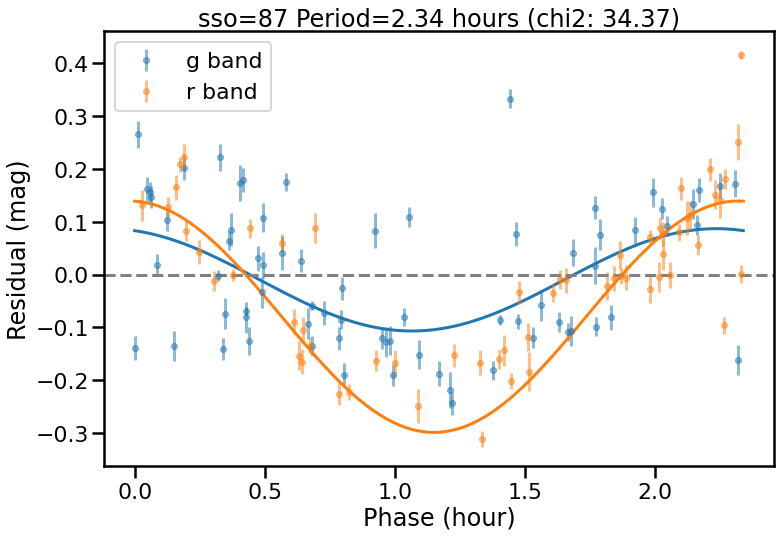

In [8]:
fig = plt.figure(figsize=(12, 8))

tfit = np.linspace(0, period/24, 100)
magfit = model.model(tfit, 1/period*24)
colors = ["C0", "C1"]
dicband = {1: "g", 2: "r"}
for index, (color, filtnum) in enumerate(zip(colors, pdf["i:fid"].unique())):
    cond = pdf['i:fid'] == filtnum    
    phase = pdf["i:jd"][cond] % (period/24)
    plt.errorbar(
        phase*24, 
        pdf["residuals"][cond], 
        pdf['i:sigmapsf'][cond], 
        ls="", marker='.', alpha=0.5, color=color, label="{} band".format(dicband[filtnum])
    )
    plt.plot(tfit*24, magfit[index], ls="-", marker='', color=color)
plt.axhline(0, ls="--", color="grey")
# plt.ylim(-0.7, 0.7)
plt.title("sso={} Period={:.2f} hours (chi2: {:.2f})".format(ssnamenr, period, chi2red))
plt.xlabel("Phase (hour)")
plt.ylabel("Residual (mag)")
plt.legend();

## Higher frequency terms

Let's complexify our model by setting `Nterms_base` to 2

In [9]:
flavor = "SHG1G2"

# Sylvia
ssnamenr = 87
period_range = (1 / 24, 7) # 1hour to 7 days

t0 = time.time()
period, chi2red, frequency, power, model, pdf = estimate_synodic_period(
    ssnamenr=ssnamenr, flavor=flavor, Nterms_base=2, period_range=period_range, return_extra_info=True
)

print(
    "[{:.2f} seconds] model={}: period={:.2f} hours (chi2red={:.2f}) -- BFT: period={:.2f} hours".format(
        time.time() - t0,
        flavor,
        period,
        chi2red,
        bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0]
    )
)

[21.91 seconds] model=SHG1G2: period=5.18 hours (chi2red=24.67) -- BFT: period=5.18 hours


Much better! But much slower as well :D

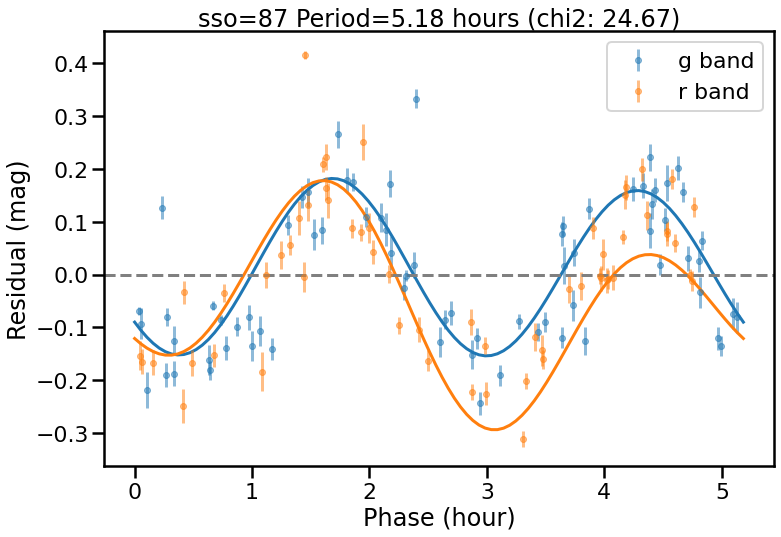

In [10]:
fig = plt.figure(figsize=(12, 8))

tfit = np.linspace(0, period/24, 100)
magfit = model.model(tfit, 1/period*24)
colors = ["C0", "C1"]
dicband = {1: "g", 2: "r"}
for index, (color, filtnum) in enumerate(zip(colors, pdf["i:fid"].unique())):
    cond = pdf['i:fid'] == filtnum    
    phase = pdf["i:jd"][cond] % (period/24)
    plt.errorbar(
        phase*24, 
        pdf["residuals"][cond], 
        pdf['i:sigmapsf'][cond], 
        ls="", marker='.', alpha=0.5, color=color, label="{} band".format(dicband[filtnum])
    )
    plt.plot(tfit*24, magfit[index], ls="-", marker='', color=color)
plt.axhline(0, ls="--", color="grey")
# plt.ylim(-0.7, 0.7)
plt.title("sso={} Period={:.2f} hours (chi2: {:.2f})".format(ssnamenr, period, chi2red))
plt.xlabel("Phase (hour)")
plt.ylabel("Residual (mag)")
plt.legend();

## Periodogram

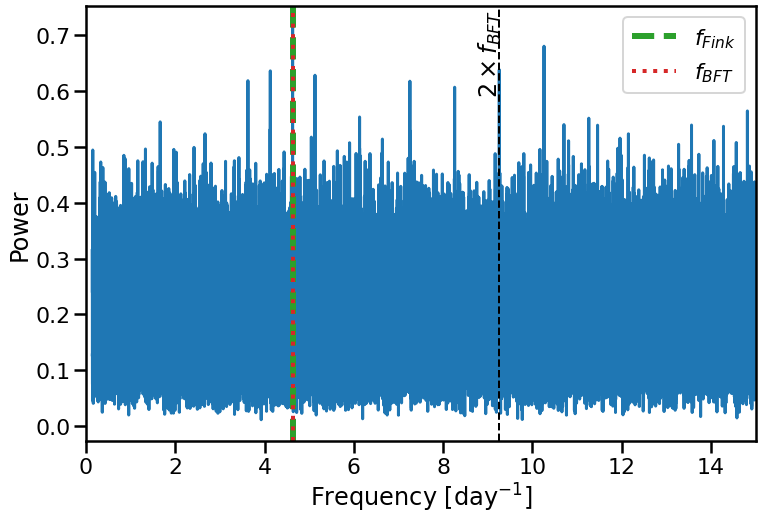

In [18]:
period_bft = bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0]

fig = plt.figure(figsize=(12, 8))
plt.plot(frequency, power)
plt.axvline(1/period*24, ls='--', lw=6, color='C2', label=r"$f_{Fink}$")
plt.axvline(1/period_bft * 24, ls=':', lw=4, color='C3', label=r"$f_{BFT}$")

offset = -0.5
offset_y = 0.1
plt.text(1/period_bft * 24 * 2 + offset, 0.6, r"$2 \times f_{BFT}$", rotation=90)

plt.axvline(1/period_bft * 24 * 2, ls='--', lw=2, color='black')

plt.xlim(0, 15)
plt.xlabel(r"Frequency [day$^{-1}$]")
plt.ylabel("Power")
plt.legend();

Noisy with many peaks above the noise, but not many aliases of the main frequency. Let's capture all frequencies above 0.6:

In [51]:
tmp = frequency[np.where(power > 0.6)]
freqs = tmp[:-1][np.diff(tmp) > 0.2] # differ from at leat 0.5 day^-1

# discard the main freq
freqs = freqs[abs(freqs - 1/period*24) > 0.1]
freqs, 1 / freqs * 24

(array([3.6284478 , 4.12965888, 5.13093094, 7.25688017, 8.25930232,
        9.25942429]),
 array([6.61439858, 5.81161803, 4.67751375, 3.30720633, 2.90581445,
        2.5919538 ]))

We obtain 6 frequencies, that are actually $[\alpha, \beta, \gamma, 2\alpha, 2\beta, 2\gamma]$ with:

| Name | Frequency (day$^{-1}$) | Period (hour) |
|-|-|-|
| $\alpha$ | 3.63 | 6.61 |
| $\beta$ | 4.13 | 5.81 |
| $\gamma$ | 5.13 | 4.68 |

Let's visualise them:

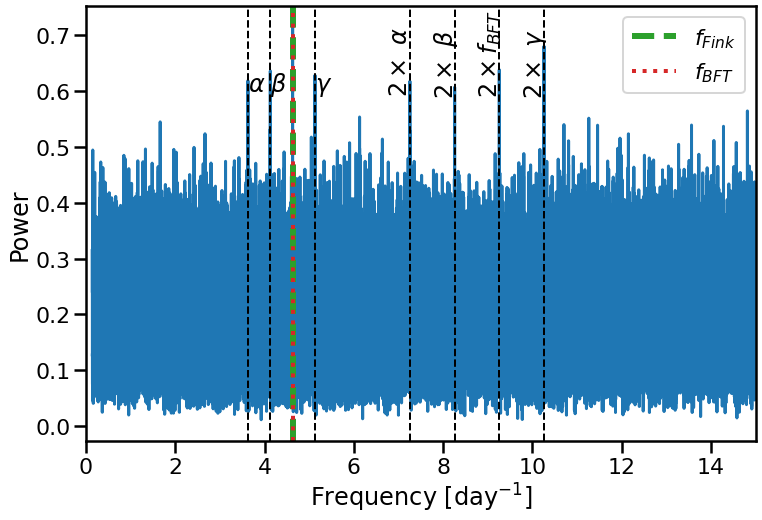

In [50]:
fig = plt.figure(figsize=(12, 8))
plt.plot(frequency, power)
plt.axvline(1/period*24, ls='--', lw=6, color='C2', label=r"$f_{Fink}$")
plt.axvline(1/period_bft * 24, ls=':', lw=4, color='C3', label=r"$f_{BFT}$")

offset = -0.5
offset_y = 0.1
plt.text(1/period_bft * 24 * 2 + offset, 0.6, r"$2 \times f_{BFT}$", rotation=90)
plt.axvline(1/period_bft * 24 * 2, ls='--', lw=2, color='black')

names = [r"$\alpha$", r"$\beta$", r"$\gamma$"]
for name, freq in zip(names, freqs[:3]):
    plt.text(freq, 0.6, name, rotation=0)
    plt.axvline(freq, ls='--', lw=2, color='black')

    plt.text(2 * freq + offset, 0.6, r"$2 \times$ {}".format(name), rotation=90)
    plt.axvline(2 * freq, ls='--', lw=2, color='black')
    

plt.xlim(0, 15)
plt.xlabel(r"Frequency [day$^{-1}$]")
plt.ylabel("Power")
plt.legend();